# LSTM
Long Short-Term Memory

In [1]:
import glob
import os
from pathlib import Path
from scipy.io import wavfile

import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.nn import functional as F
# Dataset
from torch.utils.data import DataLoader, Dataset, random_split
from torch.nn import CrossEntropyLoss, LogSoftmax


import librosa
import librosa.display
import IPython.display as ipd

from tqdm.notebook import tqdm
# from google_drive_downloader import GoogleDriveDownloader as gdd

## AudioDataset Class

In [2]:
sliced_dataset = "short_audio_dataset"
sliced_dataset_lenght = 16050
# sliced_dataset = "shorter_audio_dataset"
# sliced_dataset_lenght = 4013
original_dataset = "audio_dataset"
original_dataset_lenght = 80249

class AudioDataset(Dataset):
    def __init__(self, root_path="./data/", drop_both=False, use_short=False, active='wavs', normalize=False):
        root_folder = root_path + original_dataset if not use_short else root_path + sliced_dataset
        self.max_length = original_dataset_lenght if not use_short else sliced_dataset_lenght
        self.class_map = {"esben" : 0, "peter": 1, "both": 2}
        self.data = []
        self.labels = []
        self.min_val = 10e10
        self.max_val = 0
        self.normalize = normalize
        self.wavs, self.mfccs, self.chromas, self.contrasts, self.centroids, self.bandwidths = [], [], [], [], [], []
        self.wavs_norm, self.mfccs_norm, self.chromas_norm, self.contrasts_norm, self.centroids_norm, self.bandwidths_norm = [], [], [], [], [], []
        
        print("Start reading files and genearting features")
        for subdir, dirs, files in os.walk(root_folder):
            for file_name in files:
                if drop_both and "both" in subdir:
                   continue
        
                file_path = os.path.join(subdir, file_name)
                self.sample_rate, wav = wavfile.read(file_path)
                wav = wav.astype(np.float32)
                
                if wav.shape[0] > self.max_length:
                    self.max_length = wav.shape[0]
                    print("Found wav with more length than specified max one, new max is:", wav.shape[0])
                
                self.feature_extraction(wav, self.sample_rate)
                wav = np.pad(wav, (0, self.max_length-wav.shape[0]))
                label_str = file_path.split('/')[-3][2:]
                label = (np.int64(self.class_map[label_str]))
                
                self.max_val = np.max(wav) if np.max(wav) > self.max_val else self.max_val
                self.min_val = np.min(wav) if np.min(wav) < self.min_val else self.min_val
                
                self.wavs.append(wav)
                self.labels.append(label)
               
        self.wavs = np.array(self.wavs)
        self.mu  = self.wavs.mean()
        self.std = np.std(self.wavs)
        # self.wavs = torch.Tensor(self.wavs)

        self.active = active
        self.values_dict = {'wavs': 0, 'mfcc': 1, 'chroma': 2, 'contrast': 3, 'centroid': 4, 'bandwidth': 5}
        self.values_list = [self.wavs, self.mfccs, self.chromas, self.contrasts, self.centroids, self.bandwidths]
        self.values_norm_list = []
        print("Generating normalized arrays")
        for lst in self.values_list:
            self.values_norm_list.append((lst + np.abs(np.min(lst))) / (np.abs(np.min(lst)) + np.max(lst)))
            
        print("="*40)
        print("Loaded DATABASE from {}\n{} total file\nLongest file is {} long\nMean: {}\nStandard deviation: {}\n".
              format(root_folder, len(self.wavs), self.max_length, self.mu, self.std))
        print("="*40)

    def feature_extraction(self, wav, sample_rate):
        self.mfccs.append(np.transpose(np.mean(librosa.feature.mfcc(y=wav, sr=sample_rate, n_mfcc=128).T, axis=0)))
        # self.chromas.append(np.transpose(np.mean(librosa.feature.chroma_cqt(y=wav, sr=sample_rate).T, axis=0)))
        self.chromas.append(np.transpose(np.mean(librosa.feature.chroma_stft(y=wav, sr=sample_rate).T, axis=0)))
        self.contrasts.append(np.transpose(np.mean(librosa.feature.spectral_contrast(y=wav, sr=sample_rate).T, axis=0)))
        self.centroids.append(np.transpose(np.mean(librosa.feature.spectral_centroid(y=wav, sr=sample_rate).T, axis=0)))
        self.bandwidths.append(np.transpose(np.mean(librosa.feature.spectral_bandwidth(y=wav, sr=sample_rate).T, axis=0)))

    def __len__(self):
        return len(self.wavs)
    
    def __getitem__(self, idx):
        y = self.labels[idx]
        x = self.values_list[self.values_dict[self.active]][idx]
        if self.normalize:
            x = self.values_norm_list[self.values_dict[self.active]][idx]
        x = torch.Tensor(x)
        return x, y


Data Generation

In [3]:
# Load data

batch_size = 15
drop_both = True
if drop_both == False:
    num_classes = 3
else: 
    num_classes = 2
audio_dataset = AudioDataset(root_path="../data/", drop_both=drop_both, use_short=True)
dataset_len = len(audio_dataset)
train_size, test_size, valid_size = round(dataset_len * 0.7), round(dataset_len * 0.2), round(dataset_len * 0.1)

dataset_train, dataset_test, dataset_valid = torch.utils.data.random_split(audio_dataset, (train_size, test_size, valid_size))

kwargs = {'batch_size': batch_size, 'num_workers': 1}
loader_train = torch.utils.data.DataLoader(dataset_train, **kwargs, shuffle=True)
loader_test = torch.utils.data.DataLoader(dataset_test, **kwargs, shuffle=True)
loader_valid = torch.utils.data.DataLoader(dataset_valid, **kwargs, shuffle=True)

# 33% should be considered like with the other methods 

Start reading files and genearting features
Generating normalized arrays
Loaded DATABASE from ../data/short_audio_dataset
1000 total file
Longest file is 16050 long
Mean: -0.6988561153411865
Standard deviation: 2332.388916015625



In [4]:
class voiceClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(voiceClassifier, self).__init__()  
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers) # Long Short Term Memory Layer -> 
        self.fc = nn.Linear(hidden_size, output_size)
        # self.sigmoid = nn.Sigmoid()  # Could only be used when both was not used - binary classification

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(1), self.hidden_size).to(x.device) # initial hiddens
        c0 = torch.zeros(self.num_layers, x.size(1), self.hidden_size).to(x.device) # initial cell states
        
        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))  # Output shape: (batch_size, seq_length, hidden_size)
        
        # Decode the hidden state of the last time step
        out = self.fc(out)
        # output = self.sigmoid(out)  # Sigmoid for binary classification
        output = F.softmax(out, dim=1)  # Softmax for multi-class classification

        return output


**Testing Different features**

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [1/50], Train Loss: 0.6932, Train Acc: 0.5357, Valid Loss: 0.6931, Valid Acc: 0.4800
Epoch [2/50], Train Loss: 0.6931, Train Acc: 0.6486, Valid Loss: 0.6931, Valid Acc: 0.4800
Epoch [3/50], Train Loss: 0.6931, Train Acc: 0.6986, Valid Loss: 0.6931, Valid Acc: 0.4700
Epoch [4/50], Train Loss: 0.6931, Train Acc: 0.5371, Valid Loss: 0.6931, Valid Acc: 0.4800
Epoch [5/50], Train Loss: 0.6931, Train Acc: 0.5971, Valid Loss: 0.6931, Valid Acc: 0.5500
Epoch [6/50], Train Loss: 0.6931, Train Acc: 0.6100, Valid Loss: 0.6931, Valid Acc: 0.5200
Epoch [7/50], Train Loss: 0.6931, Train Acc: 0.5886, Valid Loss: 0.6931, Valid Acc: 0.5300
Epoch [8/50], Train Loss: 0.6931, Train Acc: 0.5500, Valid Loss: 0.6931, Valid Acc: 0.5300
Epoch [9/50], Train Loss: 0.6931, Train Acc: 0.5200, Valid Loss: 0.6931, Valid Acc: 0.4500
Epoch [10/50], Train Loss: 0.6931, Train Acc: 0.5286, Valid Loss: 0.6931, Valid Acc: 0.5300
Epoch [11/50], Train Loss: 0.6931, Train Acc: 0.5343, Valid Loss: 0.6931, Valid Acc: 0.48

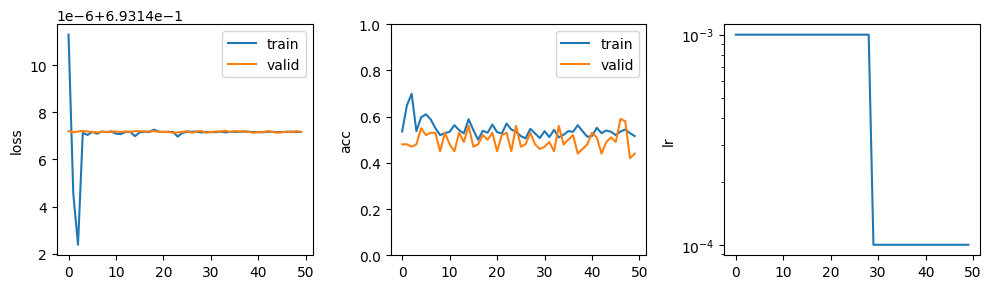

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [1/50], Train Loss: 0.6928, Train Acc: 0.6814, Valid Loss: 0.6921, Valid Acc: 0.7000
Epoch [2/50], Train Loss: 0.6893, Train Acc: 0.7529, Valid Loss: 0.6834, Valid Acc: 0.7200
Epoch [3/50], Train Loss: 0.6763, Train Acc: 0.7386, Valid Loss: 0.6682, Valid Acc: 0.7500
Epoch [4/50], Train Loss: 0.6569, Train Acc: 0.7843, Valid Loss: 0.6443, Valid Acc: 0.7900
Epoch [5/50], Train Loss: 0.6465, Train Acc: 0.8014, Valid Loss: 0.6372, Valid Acc: 0.8300
Epoch [6/50], Train Loss: 0.6411, Train Acc: 0.8443, Valid Loss: 0.6333, Valid Acc: 0.8800
Epoch [7/50], Train Loss: 0.6395, Train Acc: 0.8386, Valid Loss: 0.6398, Valid Acc: 0.8600
Epoch [8/50], Train Loss: 0.6374, Train Acc: 0.8486, Valid Loss: 0.6362, Valid Acc: 0.8500
Epoch [9/50], Train Loss: 0.6377, Train Acc: 0.8429, Valid Loss: 0.6351, Valid Acc: 0.8800
Epoch [10/50], Train Loss: 0.6366, Train Acc: 0.8557, Valid Loss: 0.6312, Valid Acc: 0.9000
Epoch [11/50], Train Loss: 0.6365, Train Acc: 0.8643, Valid Loss: 0.6310, Valid Acc: 0.93

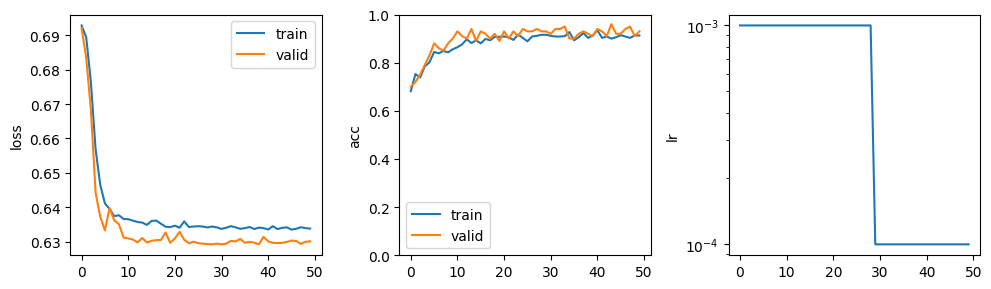

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [1/50], Train Loss: 0.6923, Train Acc: 0.6143, Valid Loss: 0.6915, Valid Acc: 0.6100
Epoch [2/50], Train Loss: 0.6877, Train Acc: 0.6357, Valid Loss: 0.6834, Valid Acc: 0.6800
Epoch [3/50], Train Loss: 0.6800, Train Acc: 0.6514, Valid Loss: 0.6706, Valid Acc: 0.6800
Epoch [4/50], Train Loss: 0.6740, Train Acc: 0.6443, Valid Loss: 0.6778, Valid Acc: 0.6700
Epoch [5/50], Train Loss: 0.6737, Train Acc: 0.6286, Valid Loss: 0.6845, Valid Acc: 0.6300
Epoch [6/50], Train Loss: 0.6738, Train Acc: 0.6214, Valid Loss: 0.6878, Valid Acc: 0.6300
Epoch [7/50], Train Loss: 0.6686, Train Acc: 0.6429, Valid Loss: 0.6779, Valid Acc: 0.6600
Epoch [8/50], Train Loss: 0.6721, Train Acc: 0.6314, Valid Loss: 0.6661, Valid Acc: 0.6500
Epoch [9/50], Train Loss: 0.6698, Train Acc: 0.6271, Valid Loss: 0.6671, Valid Acc: 0.6600
Epoch [10/50], Train Loss: 0.6728, Train Acc: 0.6286, Valid Loss: 0.6744, Valid Acc: 0.6400
Epoch [11/50], Train Loss: 0.6691, Train Acc: 0.6414, Valid Loss: 0.6753, Valid Acc: 0.65

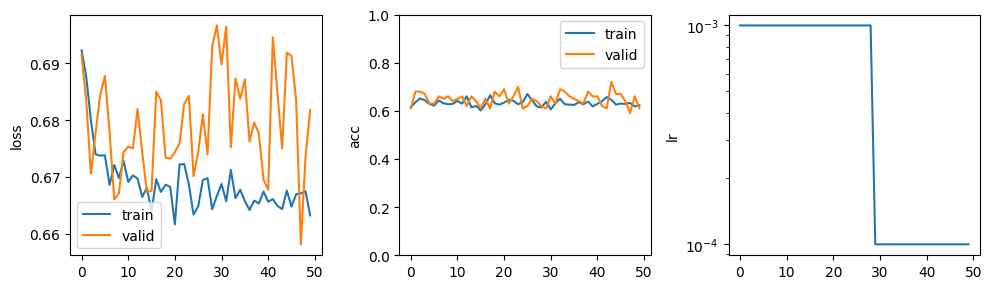

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [1/50], Train Loss: 0.6928, Train Acc: 0.6600, Valid Loss: 0.6923, Valid Acc: 0.7300
Epoch [2/50], Train Loss: 0.6905, Train Acc: 0.6600, Valid Loss: 0.6878, Valid Acc: 0.6800
Epoch [3/50], Train Loss: 0.6842, Train Acc: 0.6600, Valid Loss: 0.6778, Valid Acc: 0.7100
Epoch [4/50], Train Loss: 0.6766, Train Acc: 0.6443, Valid Loss: 0.6692, Valid Acc: 0.7500
Epoch [5/50], Train Loss: 0.6698, Train Acc: 0.6743, Valid Loss: 0.6752, Valid Acc: 0.7200
Epoch [6/50], Train Loss: 0.6671, Train Acc: 0.6771, Valid Loss: 0.6709, Valid Acc: 0.7400
Epoch [7/50], Train Loss: 0.6652, Train Acc: 0.6957, Valid Loss: 0.6710, Valid Acc: 0.7100
Epoch [8/50], Train Loss: 0.6646, Train Acc: 0.6771, Valid Loss: 0.6699, Valid Acc: 0.7400
Epoch [9/50], Train Loss: 0.6594, Train Acc: 0.6900, Valid Loss: 0.6586, Valid Acc: 0.7300
Epoch [10/50], Train Loss: 0.6596, Train Acc: 0.6971, Valid Loss: 0.6583, Valid Acc: 0.7400
Epoch [11/50], Train Loss: 0.6587, Train Acc: 0.6986, Valid Loss: 0.6610, Valid Acc: 0.75

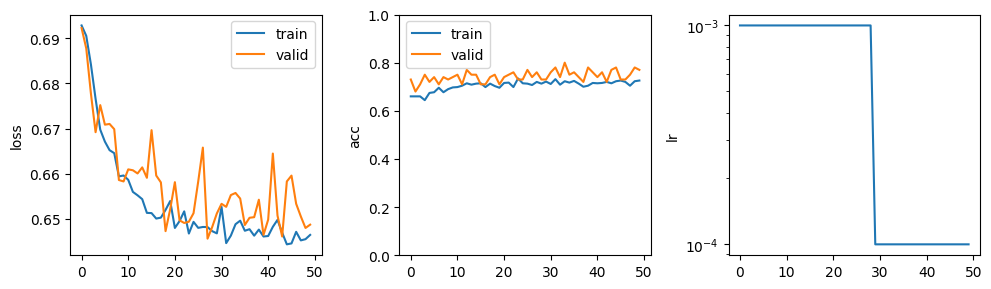

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [1/50], Train Loss: 0.6933, Train Acc: 0.4843, Valid Loss: 0.6946, Valid Acc: 0.4700
Epoch [2/50], Train Loss: 0.6900, Train Acc: 0.5886, Valid Loss: 0.6938, Valid Acc: 0.4500
Epoch [3/50], Train Loss: 0.6871, Train Acc: 0.6243, Valid Loss: 0.6935, Valid Acc: 0.5000
Epoch [4/50], Train Loss: 0.6838, Train Acc: 0.6657, Valid Loss: 0.6943, Valid Acc: 0.4800
Epoch [5/50], Train Loss: 0.6801, Train Acc: 0.6786, Valid Loss: 0.6941, Valid Acc: 0.5200
Epoch [6/50], Train Loss: 0.6778, Train Acc: 0.7071, Valid Loss: 0.6940, Valid Acc: 0.5100
Epoch [7/50], Train Loss: 0.6749, Train Acc: 0.7186, Valid Loss: 0.6935, Valid Acc: 0.5400
Epoch [8/50], Train Loss: 0.6712, Train Acc: 0.7257, Valid Loss: 0.6933, Valid Acc: 0.4800
Epoch [9/50], Train Loss: 0.6680, Train Acc: 0.7271, Valid Loss: 0.6923, Valid Acc: 0.5100
Epoch [10/50], Train Loss: 0.6661, Train Acc: 0.7357, Valid Loss: 0.6981, Valid Acc: 0.5000
Epoch [11/50], Train Loss: 0.6641, Train Acc: 0.7371, Valid Loss: 0.6947, Valid Acc: 0.48

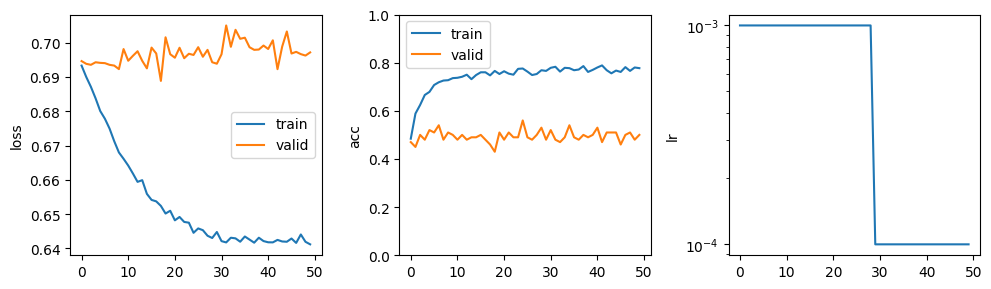

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [1/50], Train Loss: 0.6719, Train Acc: 0.7786, Valid Loss: 0.6399, Valid Acc: 0.8600
Epoch [2/50], Train Loss: 0.6389, Train Acc: 0.8614, Valid Loss: 0.6293, Valid Acc: 0.8900
Epoch [3/50], Train Loss: 0.6340, Train Acc: 0.9100, Valid Loss: 0.6287, Valid Acc: 0.9500
Epoch [4/50], Train Loss: 0.6324, Train Acc: 0.9200, Valid Loss: 0.6285, Valid Acc: 0.9300
Epoch [5/50], Train Loss: 0.6325, Train Acc: 0.9171, Valid Loss: 0.6277, Valid Acc: 0.9400
Epoch [6/50], Train Loss: 0.6324, Train Acc: 0.9071, Valid Loss: 0.6274, Valid Acc: 0.9400
Epoch [7/50], Train Loss: 0.6325, Train Acc: 0.9171, Valid Loss: 0.6276, Valid Acc: 0.9400
Epoch [8/50], Train Loss: 0.6325, Train Acc: 0.9214, Valid Loss: 0.6320, Valid Acc: 0.9400
Epoch [9/50], Train Loss: 0.6317, Train Acc: 0.9200, Valid Loss: 0.6279, Valid Acc: 0.9300
Epoch [10/50], Train Loss: 0.6311, Train Acc: 0.9329, Valid Loss: 0.6273, Valid Acc: 0.9400
Epoch [11/50], Train Loss: 0.6303, Train Acc: 0.9286, Valid Loss: 0.6268, Valid Acc: 0.94

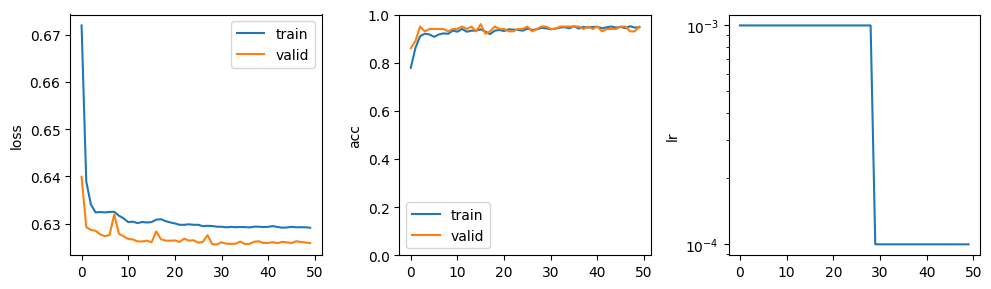

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [1/50], Train Loss: 0.6923, Train Acc: 0.6043, Valid Loss: 0.6901, Valid Acc: 0.6600
Epoch [2/50], Train Loss: 0.6871, Train Acc: 0.6500, Valid Loss: 0.6843, Valid Acc: 0.6600
Epoch [3/50], Train Loss: 0.6766, Train Acc: 0.6386, Valid Loss: 0.6829, Valid Acc: 0.6800
Epoch [4/50], Train Loss: 0.6740, Train Acc: 0.6414, Valid Loss: 0.6783, Valid Acc: 0.6700
Epoch [5/50], Train Loss: 0.6725, Train Acc: 0.6543, Valid Loss: 0.6746, Valid Acc: 0.6600
Epoch [6/50], Train Loss: 0.6708, Train Acc: 0.6257, Valid Loss: 0.6730, Valid Acc: 0.6800
Epoch [7/50], Train Loss: 0.6711, Train Acc: 0.6271, Valid Loss: 0.6749, Valid Acc: 0.5800
Epoch [8/50], Train Loss: 0.6733, Train Acc: 0.6443, Valid Loss: 0.6873, Valid Acc: 0.6200
Epoch [9/50], Train Loss: 0.6740, Train Acc: 0.5986, Valid Loss: 0.6813, Valid Acc: 0.6700
Epoch [10/50], Train Loss: 0.6696, Train Acc: 0.6329, Valid Loss: 0.6801, Valid Acc: 0.6400
Epoch [11/50], Train Loss: 0.6723, Train Acc: 0.6171, Valid Loss: 0.6832, Valid Acc: 0.64

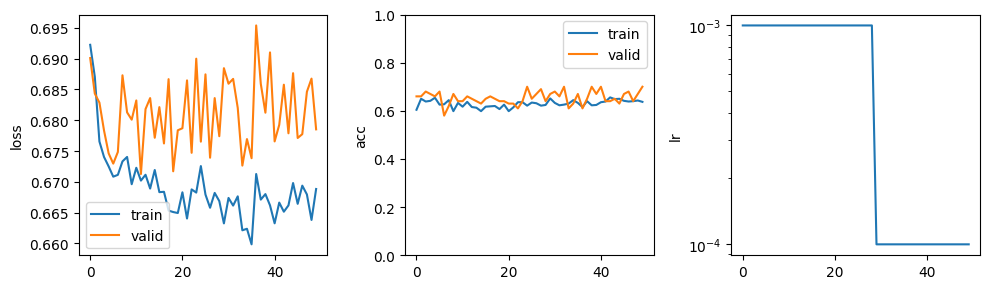

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [1/50], Train Loss: 0.6836, Train Acc: 0.6700, Valid Loss: 0.6711, Valid Acc: 0.7000
Epoch [2/50], Train Loss: 0.6588, Train Acc: 0.7100, Valid Loss: 0.6538, Valid Acc: 0.7000
Epoch [3/50], Train Loss: 0.6503, Train Acc: 0.7186, Valid Loss: 0.6476, Valid Acc: 0.6600
Epoch [4/50], Train Loss: 0.6483, Train Acc: 0.7200, Valid Loss: 0.6648, Valid Acc: 0.6400
Epoch [5/50], Train Loss: 0.6497, Train Acc: 0.7129, Valid Loss: 0.6491, Valid Acc: 0.6300
Epoch [6/50], Train Loss: 0.6468, Train Acc: 0.7100, Valid Loss: 0.6513, Valid Acc: 0.7000
Epoch [7/50], Train Loss: 0.6492, Train Acc: 0.7100, Valid Loss: 0.6509, Valid Acc: 0.7500
Epoch [8/50], Train Loss: 0.6492, Train Acc: 0.7200, Valid Loss: 0.6515, Valid Acc: 0.6500
Epoch [9/50], Train Loss: 0.6513, Train Acc: 0.7329, Valid Loss: 0.6489, Valid Acc: 0.7400
Epoch [10/50], Train Loss: 0.6479, Train Acc: 0.7243, Valid Loss: 0.6488, Valid Acc: 0.6600
Epoch [11/50], Train Loss: 0.6491, Train Acc: 0.7086, Valid Loss: 0.6417, Valid Acc: 0.75

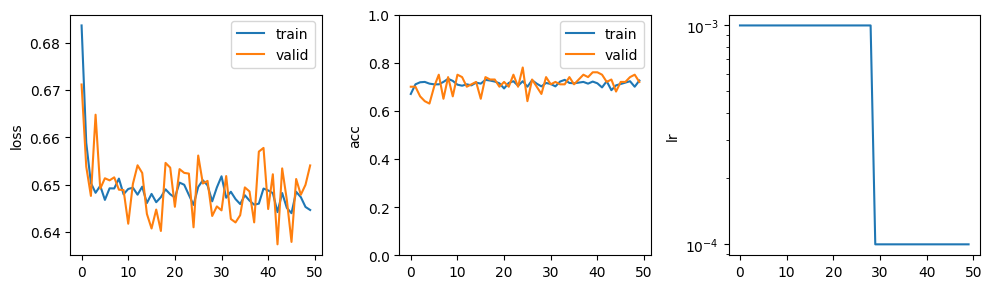

In [6]:
num_layers = 1  # Number of LSTM layers

device = torch.device('cuda')
with open('../output/results_short_lstm.txt', "w") as f:
  for norm in (True, False):
    audio_dataset.normalize = norm
    for feature in ('wavs', 'mfcc', 'chroma', 'contrast'):  
        audio_dataset.active = feature
        for n_hidden_neurons in ([500]):
            model = voiceClassifier(int(audio_dataset[0][0].shape[0]), n_hidden_neurons, num_layers, num_classes)
            #opt = torch.optim.SGD(model.parameters(), lr=5e-2)
            opt = torch.optim.Adam(model.parameters(), lr=1e-3)
            sched = torch.optim.lr_scheduler.MultiStepLR(opt, (30,))
            train_losses, train_accuracies = [], []
            valid_losses, valid_accuracies = [], []
            lrs = []
    
            for epoch in tqdm(range(50)):
                # Train
                model.train()
                losses=[]
                #train_losses = []
                train_correct = 0
                train_total = 0
                for x, y in loader_train:
                    opt.zero_grad()
                    x = x.unsqueeze(0)
                    logits = model(x)
                    logits = logits.squeeze()

                    # make target out of vector
                    one_hot_targets = torch.zeros(logits.size(0), num_classes) # empty tensor to hold the one-hot encoded targets
                    for idx, target in enumerate(y): # Fill one-hot encoded values based on the target values
                        one_hot_targets[idx, target] = 1
                    loss_func = nn.CrossEntropyLoss()  # Define the loss function
                    
                    #print("targets: ", one_hot_targets)
                    loss = loss_func(logits, one_hot_targets)  # Calculate the loss directly
                
                    # Backpropagation and parameter updates
                    loss.backward()
                    opt.step()
                    losses.append(loss.item())
                    train_total += y.size(0)
                    train_correct += (torch.argmax(logits, dim=1) == y.view(-1)).sum().item()
                    
                avg_train_loss = np.mean(losses) #added from old
                train_accuracy = train_correct / train_total

                # History - Saved for plotting 
                train_losses.append(avg_train_loss)
                train_accuracies.append(train_accuracy)
                
                # Validation
                model.eval()
                losses = []
                valid_correct = 0
                valid_total = 0
                
                for x, y in loader_valid:
                    x = x.unsqueeze(0)  # Add a batch dimension assuming it's a single sequence
                    with torch.no_grad():
                        logits = model(x)
                    logits = logits.squeeze()
                    one_hot_targets = torch.zeros(logits.size(0), num_classes) # empty tensor to hold the one-hot encoded targets
                    for idx, target in enumerate(y): # Fill one-hot encoded values based on the target values
                        one_hot_targets[idx, target] = 1
            
                    loss_func = nn.CrossEntropyLoss()  # Define the loss function
                    loss = loss_func(logits, one_hot_targets)  # Calculate the loss directly
            
                    losses.append(loss.item())
                    valid_total += y.size(0)
                    valid_correct += (torch.argmax(logits, dim=1) == y.view(-1)).sum().item()
            
                        
                avg_valid_loss = np.mean(losses) # added from old
                valid_accuracy = valid_correct / valid_total
                #avg_valid_loss = sum(losses) / len(losses)
                
               
                
                valid_losses.append(avg_valid_loss)
                valid_accuracies.append(valid_accuracy)
                
                print(f"Epoch [{epoch + 1}/50], "
                      f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.4f}, "
                      f"Valid Loss: {avg_valid_loss:.4f}, Valid Acc: {valid_accuracy:.4f}")

# Test
                model.eval()
                losses = []
                test_correct = 0
                test_total = 0
                
                for x, y in loader_test:
                    x = x.unsqueeze(0)  # Add a batch dimension assuming it's a single sequence
                    with torch.no_grad():
                        logits = model(x)
                    logits = logits.squeeze()
                
                    test_total += y.size(0)
                    test_correct += (torch.argmax(logits, dim=1) == y.view(-1)).sum().item()
            
                        
                #avg_valid_loss = np.mean(losses) # added from old
                test_accuracy = valid_correct / valid_total
                #avg_valid_loss = sum(losses) / len(losses)
                
                # sched
                sched.step()
                # history - saved for plotting
                lrs.append(next(iter(opt.param_groups))['lr'])
                
        # Print to File
        f.writelines(f"Norm: {norm}, Feature: {feature}\n")
        f.writelines(f"Train loss: {train_losses}\nTrain accuracy: {train_accuracies}\n")
        f.writelines(f"Valid loss: {valid_losses}\nValid accuracy: {valid_accuracies}\n")
        f.writelines(f"Test accuracy: {test_accuracy}\n")
    
        # plot history
        fig, axs = plt.subplots(1, 3, figsize=(10, 3))
        axs[0].plot(train_losses, label='train')
        axs[0].plot(valid_losses, label='valid')
                    
        axs[0].set_ylabel('loss')
        axs[0].legend()
        axs[1].plot(train_accuracies, label='train')
        axs[1].plot(valid_accuracies, label='valid')
        axs[1].set_ylabel('acc')
        axs[1].set_ylim(0, 1)
        axs[1].legend()
        axs[2].plot(lrs)
        axs[2].set_ylabel('lr')
        axs[2].set_yscale('log')
        plt.tight_layout()
        plt.show()
             

**Testing Different Hyperparameters**

In [6]:
# LIST OF HYPER PARAMETERS THAT WE WANT TO CHANGE
hidden_neurons = [10, 100, 500, 1000]
learning_rates = [0.01, 0.001, 0.0001]
batch_sizes = [2, 8, 32, 128]
n_layers = [2, 4, 6]

device = torch.device('cuda')
num_classes = 3
with open('../output/results_short_hyp_LSTM.txt', "w") as f:
  audio_dataset.normalize = False
  audio_dataset.active = "mfcc"
  for n_hidden_neurons in hidden_neurons:
    for layers in n_layers:
      for lr in learning_rates:
        for batch_size in batch_sizes:
            kwargs = {'batch_size': batch_size, 'num_workers': 8}
            loader_train = torch.utils.data.DataLoader(dataset_train, **kwargs, shuffle=True)
            loader_test = torch.utils.data.DataLoader(dataset_test, **kwargs, shuffle=True)
            loader_valid = torch.utils.data.DataLoader(dataset_valid, **kwargs, shuffle=True)
            model = voiceClassifier(int(audio_dataset[0][0].shape[0]), n_hidden_neurons, layers, num_classes)
            opt = torch.optim.Adam(model.parameters(), lr)
            sched = torch.optim.lr_scheduler.MultiStepLR(opt, (30,))
            train_losses, train_accuracies = [], []
            valid_losses, valid_accuracies = [], []
            lrs = []
        
            for epoch in tqdm(range(50)):
# Train
                model.train()
                losses=[]
                #train_losses = []
                train_correct = 0
                train_total = 0
                for x, y in loader_train:
                    opt.zero_grad()
                    x = x.unsqueeze(0)
                    logits = model(x)
                    logits = logits.squeeze()
                    #print("logits: ", logits.shape)
                    # make target out of vector
                    one_hot_targets = torch.zeros(logits.size(0), num_classes) # empty tensor to hold the one-hot encoded targets
                    for idx, target in enumerate(y): # Fill one-hot encoded values based on the target values
                        one_hot_targets[idx, target] = 1

                    loss_func = nn.CrossEntropyLoss()  # Define the loss function
                    loss = loss_func(logits, one_hot_targets)  # Calculate the loss directly
                
                    # Backpropagation and parameter updates
                    loss.backward()
                    opt.step()
                    losses.append(loss.item())
                    train_total += y.size(0)
                    train_correct += (torch.argmax(logits, dim=1) == y.view(-1)).sum().item()
                    
                avg_train_loss = np.mean(losses) #added from old
                train_accuracy = train_correct / train_total

                # History - Saved for plotting 
                train_losses.append(avg_train_loss)
                train_accuracies.append(train_accuracy)
                
# Validation
                model.eval()
                losses = []
                valid_correct = 0
                valid_total = 0
                
                for x, y in loader_valid:
                    x = x.unsqueeze(0)  # Add a batch dimension assuming it's a single sequence
                    with torch.no_grad():
                        logits = model(x)
                    logits = logits.squeeze()
                    one_hot_targets = torch.zeros(logits.size(0), num_classes) # empty tensor to hold the one-hot encoded targets
                    for idx, target in enumerate(y): # Fill one-hot encoded values based on the target values
                        one_hot_targets[idx, target] = 1
            
                    loss_func = nn.CrossEntropyLoss()  # Define the loss function
                    loss = loss_func(logits, one_hot_targets)  # Calculate the loss directly
            
                    losses.append(loss.item())
                    valid_total += y.size(0)
                    valid_correct += (torch.argmax(logits, dim=1) == y.view(-1)).sum().item()
            
                        
                avg_valid_loss = np.mean(losses) # added from old
                valid_accuracy = valid_correct / valid_total
                #avg_valid_loss = sum(losses) / len(losses)
                
               
                
                valid_losses.append(avg_valid_loss)
                valid_accuracies.append(valid_accuracy)
                

# Test
                model.eval()
                losses = []
                test_correct = 0
                test_total = 0
                
                for x, y in loader_test:
                    x = x.unsqueeze(0)  # Add a batch dimension assuming it's a single sequence
                    with torch.no_grad():
                        logits = model(x)
                    logits = logits.squeeze()
            
                    #losses.append(loss.item())
                    test_total += y.size(0)
                    test_correct += (torch.argmax(logits, dim=1) == y.view(-1)).sum().item()
                        
                test_accuracy = valid_correct / valid_total
    
                # sched
                sched.step()
                # history - saved for plotting
                lrs.append(next(iter(opt.param_groups))['lr'])
# Print to File
            f.writelines(f"Norm: {audio_dataset.normalize}, Feature: {audio_dataset.active}\n")
            f.writelines(f"N_layers: {layers}, N_hidden_neurons: {n_hidden_neurons}, LR: {lr}, Batch_size: {batch_size}, Epochs: {50}\n")
            f.writelines(f"Train loss: {train_losses}\nTrain accuracy: {train_accuracies}\n")
            f.writelines(f"Valid loss: {valid_losses}\nValid accuracy: {valid_accuracies}\n")
            f.writelines(f"Test accuracy: {test_accuracy}\n")

            print(f"Hidden: {n_hidden_neurons}, Layers: {layers}, LR: {lr}, batch_size: {batch_size}, "
              f"Train Loss: {avg_train_loss:.4f}, Valid Loss: {avg_valid_loss:.4f}, "
              f"Train Acc: {train_accuracy:.4f}, Valid Acc: {valid_accuracy:.4f}, Test Acc: {test_accuracy:.4f}")
        #print("Done batch_size:", batch_size)
      #print("Done lr:", lr)
    #print("Done layers:", layers)
  #print("Done hidden_neurons:", n_hidden_neurons)

  0%|          | 0/50 [00:00<?, ?it/s]

Hidden: 10, Layers: 2, LR: 0.01, batch_size: 2, Train Loss: 1.0986, Valid Loss: 1.0986, Train Acc: 0.4900, Valid Acc: 0.5300, Test Acc: 0.5300


  0%|          | 0/50 [00:00<?, ?it/s]

Hidden: 10, Layers: 2, LR: 0.01, batch_size: 8, Train Loss: 1.0986, Valid Loss: 1.0986, Train Acc: 0.4814, Valid Acc: 0.5300, Test Acc: 0.5300


  0%|          | 0/50 [00:00<?, ?it/s]

Hidden: 10, Layers: 2, LR: 0.01, batch_size: 32, Train Loss: 1.0986, Valid Loss: 1.0986, Train Acc: 0.4829, Valid Acc: 0.5400, Test Acc: 0.5400


  0%|          | 0/50 [00:00<?, ?it/s]

Hidden: 10, Layers: 2, LR: 0.01, batch_size: 128, Train Loss: 1.0902, Valid Loss: 1.0892, Train Acc: 0.9143, Valid Acc: 0.9400, Test Acc: 0.9400


  0%|          | 0/50 [00:00<?, ?it/s]

Hidden: 10, Layers: 2, LR: 0.001, batch_size: 2, Train Loss: 0.9070, Valid Loss: 0.9280, Train Acc: 0.7386, Valid Acc: 0.7100, Test Acc: 0.7100


  0%|          | 0/50 [00:00<?, ?it/s]

Hidden: 10, Layers: 2, LR: 0.001, batch_size: 8, Train Loss: 0.9859, Valid Loss: 0.9800, Train Acc: 0.8100, Valid Acc: 0.8000, Test Acc: 0.8000


  0%|          | 0/50 [00:00<?, ?it/s]

Hidden: 10, Layers: 2, LR: 0.001, batch_size: 32, Train Loss: 1.0698, Valid Loss: 1.0223, Train Acc: 0.7729, Valid Acc: 0.7900, Test Acc: 0.7900


  0%|          | 0/50 [00:00<?, ?it/s]

Hidden: 10, Layers: 2, LR: 0.001, batch_size: 128, Train Loss: 1.0986, Valid Loss: 1.0986, Train Acc: 0.5700, Valid Acc: 0.6200, Test Acc: 0.6200


  0%|          | 0/50 [00:00<?, ?it/s]

Hidden: 10, Layers: 2, LR: 0.0001, batch_size: 2, Train Loss: 1.0578, Valid Loss: 1.0502, Train Acc: 0.6543, Valid Acc: 0.6800, Test Acc: 0.6800


  0%|          | 0/50 [00:00<?, ?it/s]

Hidden: 10, Layers: 2, LR: 0.0001, batch_size: 8, Train Loss: 1.0704, Valid Loss: 1.0649, Train Acc: 0.7529, Valid Acc: 0.7700, Test Acc: 0.7700


  0%|          | 0/50 [00:00<?, ?it/s]

Hidden: 10, Layers: 2, LR: 0.0001, batch_size: 32, Train Loss: 1.0983, Valid Loss: 1.0975, Train Acc: 0.6171, Valid Acc: 0.5700, Test Acc: 0.5700


  0%|          | 0/50 [00:00<?, ?it/s]

Hidden: 10, Layers: 2, LR: 0.0001, batch_size: 128, Train Loss: 1.0986, Valid Loss: 1.0986, Train Acc: 0.3271, Valid Acc: 0.3000, Test Acc: 0.3000


  0%|          | 0/50 [00:00<?, ?it/s]

Hidden: 10, Layers: 4, LR: 0.01, batch_size: 2, Train Loss: 1.0986, Valid Loss: 1.0986, Train Acc: 0.4886, Valid Acc: 0.5300, Test Acc: 0.5300


  0%|          | 0/50 [00:00<?, ?it/s]

Hidden: 10, Layers: 4, LR: 0.01, batch_size: 8, Train Loss: 1.0986, Valid Loss: 1.0986, Train Acc: 0.4043, Valid Acc: 0.5500, Test Acc: 0.5500


  0%|          | 0/50 [00:00<?, ?it/s]

Hidden: 10, Layers: 4, LR: 0.01, batch_size: 32, Train Loss: 1.0986, Valid Loss: 1.0986, Train Acc: 0.4886, Valid Acc: 0.5300, Test Acc: 0.5300


  0%|          | 0/50 [00:00<?, ?it/s]

Hidden: 10, Layers: 4, LR: 0.01, batch_size: 128, Train Loss: 1.0901, Valid Loss: 1.0891, Train Acc: 0.9071, Valid Acc: 0.9300, Test Acc: 0.9300


  0%|          | 0/50 [00:00<?, ?it/s]

Hidden: 10, Layers: 4, LR: 0.001, batch_size: 2, Train Loss: 0.9818, Valid Loss: 0.9780, Train Acc: 0.6786, Valid Acc: 0.7000, Test Acc: 0.7000


  0%|          | 0/50 [00:00<?, ?it/s]

Hidden: 10, Layers: 4, LR: 0.001, batch_size: 8, Train Loss: 0.9870, Valid Loss: 0.9997, Train Acc: 0.7271, Valid Acc: 0.8000, Test Acc: 0.8000


  0%|          | 0/50 [00:00<?, ?it/s]

Hidden: 10, Layers: 4, LR: 0.001, batch_size: 32, Train Loss: 1.0986, Valid Loss: 1.0986, Train Acc: 0.4886, Valid Acc: 0.5300, Test Acc: 0.5300


  0%|          | 0/50 [00:00<?, ?it/s]

Hidden: 10, Layers: 4, LR: 0.001, batch_size: 128, Train Loss: 1.0959, Valid Loss: 1.0958, Train Acc: 0.7714, Valid Acc: 0.7600, Test Acc: 0.7600


  0%|          | 0/50 [00:00<?, ?it/s]

Hidden: 10, Layers: 4, LR: 0.0001, batch_size: 2, Train Loss: 0.9419, Valid Loss: 0.9379, Train Acc: 0.7286, Valid Acc: 0.7300, Test Acc: 0.7300


  0%|          | 0/50 [00:00<?, ?it/s]

Hidden: 10, Layers: 4, LR: 0.0001, batch_size: 8, Train Loss: 1.0534, Valid Loss: 1.0461, Train Acc: 0.7357, Valid Acc: 0.7600, Test Acc: 0.7600


  0%|          | 0/50 [00:00<?, ?it/s]

Hidden: 10, Layers: 4, LR: 0.0001, batch_size: 32, Train Loss: 1.0985, Valid Loss: 1.0985, Train Acc: 0.6443, Valid Acc: 0.5900, Test Acc: 0.5900


  0%|          | 0/50 [00:00<?, ?it/s]

Hidden: 10, Layers: 4, LR: 0.0001, batch_size: 128, Train Loss: 1.0986, Valid Loss: 1.0986, Train Acc: 0.1343, Valid Acc: 0.1500, Test Acc: 0.1500


  0%|          | 0/50 [00:00<?, ?it/s]

Hidden: 10, Layers: 6, LR: 0.01, batch_size: 2, Train Loss: 1.0986, Valid Loss: 1.0986, Train Acc: 0.4843, Valid Acc: 0.5300, Test Acc: 0.5300


  0%|          | 0/50 [00:00<?, ?it/s]

Hidden: 10, Layers: 6, LR: 0.01, batch_size: 8, Train Loss: 1.0986, Valid Loss: 1.0986, Train Acc: 0.4400, Valid Acc: 0.5300, Test Acc: 0.5300


  0%|          | 0/50 [00:00<?, ?it/s]

Hidden: 10, Layers: 6, LR: 0.01, batch_size: 32, Train Loss: 1.0986, Valid Loss: 1.0986, Train Acc: 0.4886, Valid Acc: 0.5300, Test Acc: 0.5300


  0%|          | 0/50 [00:00<?, ?it/s]

Hidden: 10, Layers: 6, LR: 0.01, batch_size: 128, Train Loss: 1.0986, Valid Loss: 1.0986, Train Acc: 0.4886, Valid Acc: 0.5300, Test Acc: 0.5300


  0%|          | 0/50 [00:00<?, ?it/s]

Hidden: 10, Layers: 6, LR: 0.001, batch_size: 2, Train Loss: 0.9632, Valid Loss: 0.9836, Train Acc: 0.6957, Valid Acc: 0.7300, Test Acc: 0.7300


  0%|          | 0/50 [00:00<?, ?it/s]

Hidden: 10, Layers: 6, LR: 0.001, batch_size: 8, Train Loss: 0.9919, Valid Loss: 0.9849, Train Acc: 0.8671, Valid Acc: 0.9000, Test Acc: 0.9000


  0%|          | 0/50 [00:00<?, ?it/s]

Hidden: 10, Layers: 6, LR: 0.001, batch_size: 32, Train Loss: 1.0708, Valid Loss: 1.0289, Train Acc: 0.7243, Valid Acc: 0.7100, Test Acc: 0.7100


  0%|          | 0/50 [00:00<?, ?it/s]

Hidden: 10, Layers: 6, LR: 0.001, batch_size: 128, Train Loss: 1.0986, Valid Loss: 1.0986, Train Acc: 0.5657, Valid Acc: 0.5900, Test Acc: 0.5900


  0%|          | 0/50 [00:00<?, ?it/s]

Hidden: 10, Layers: 6, LR: 0.0001, batch_size: 2, Train Loss: 0.9474, Valid Loss: 0.9225, Train Acc: 0.7086, Valid Acc: 0.7100, Test Acc: 0.7100


  0%|          | 0/50 [00:00<?, ?it/s]

Hidden: 10, Layers: 6, LR: 0.0001, batch_size: 8, Train Loss: 1.0986, Valid Loss: 1.0986, Train Acc: 0.4886, Valid Acc: 0.5300, Test Acc: 0.5300


  0%|          | 0/50 [00:00<?, ?it/s]

Hidden: 10, Layers: 6, LR: 0.0001, batch_size: 32, Train Loss: 1.0986, Valid Loss: 1.0986, Train Acc: 0.5957, Valid Acc: 0.6200, Test Acc: 0.6200


  0%|          | 0/50 [00:00<?, ?it/s]

Hidden: 10, Layers: 6, LR: 0.0001, batch_size: 128, Train Loss: 1.0986, Valid Loss: 1.0986, Train Acc: 0.5471, Valid Acc: 0.5500, Test Acc: 0.5500


  0%|          | 0/50 [00:00<?, ?it/s]

Hidden: 100, Layers: 2, LR: 0.01, batch_size: 2, Train Loss: 1.0942, Valid Loss: 1.0989, Train Acc: 0.5414, Valid Acc: 0.6100, Test Acc: 0.6100


  0%|          | 0/50 [00:00<?, ?it/s]

Hidden: 100, Layers: 2, LR: 0.01, batch_size: 8, Train Loss: 1.0986, Valid Loss: 1.0986, Train Acc: 0.4371, Valid Acc: 0.5300, Test Acc: 0.5300


  0%|          | 0/50 [00:00<?, ?it/s]

Hidden: 100, Layers: 2, LR: 0.01, batch_size: 32, Train Loss: 1.0682, Valid Loss: 1.0190, Train Acc: 0.8671, Valid Acc: 0.8900, Test Acc: 0.8900


  0%|          | 0/50 [00:00<?, ?it/s]

Hidden: 100, Layers: 2, LR: 0.01, batch_size: 128, Train Loss: 1.0894, Valid Loss: 1.0887, Train Acc: 0.6014, Valid Acc: 0.6800, Test Acc: 0.6800


  0%|          | 0/50 [00:00<?, ?it/s]

Hidden: 100, Layers: 2, LR: 0.001, batch_size: 2, Train Loss: 0.9074, Valid Loss: 0.9043, Train Acc: 0.7429, Valid Acc: 0.7500, Test Acc: 0.7500


  0%|          | 0/50 [00:00<?, ?it/s]

Hidden: 100, Layers: 2, LR: 0.001, batch_size: 8, Train Loss: 0.9829, Valid Loss: 0.9935, Train Acc: 0.8014, Valid Acc: 0.8000, Test Acc: 0.8000


  0%|          | 0/50 [00:00<?, ?it/s]

Hidden: 100, Layers: 2, LR: 0.001, batch_size: 32, Train Loss: 1.0677, Valid Loss: 1.0188, Train Acc: 0.7400, Valid Acc: 0.7500, Test Acc: 0.7500


  0%|          | 0/50 [00:00<?, ?it/s]

Hidden: 100, Layers: 2, LR: 0.001, batch_size: 128, Train Loss: 1.0894, Valid Loss: 1.0887, Train Acc: 0.5457, Valid Acc: 0.6200, Test Acc: 0.6200


  0%|          | 0/50 [00:00<?, ?it/s]

Hidden: 100, Layers: 2, LR: 0.0001, batch_size: 2, Train Loss: 0.8975, Valid Loss: 0.9127, Train Acc: 0.7586, Valid Acc: 0.7500, Test Acc: 0.7500


  0%|          | 0/50 [00:00<?, ?it/s]

Hidden: 100, Layers: 2, LR: 0.0001, batch_size: 8, Train Loss: 0.9880, Valid Loss: 0.9932, Train Acc: 0.6471, Valid Acc: 0.6200, Test Acc: 0.6200


  0%|          | 0/50 [00:00<?, ?it/s]

Hidden: 100, Layers: 2, LR: 0.0001, batch_size: 32, Train Loss: 1.0691, Valid Loss: 1.0220, Train Acc: 0.5929, Valid Acc: 0.6600, Test Acc: 0.6600


  0%|          | 0/50 [00:00<?, ?it/s]

Hidden: 100, Layers: 2, LR: 0.0001, batch_size: 128, Train Loss: 1.0980, Valid Loss: 1.0978, Train Acc: 0.7814, Valid Acc: 0.8400, Test Acc: 0.8400


  0%|          | 0/50 [00:00<?, ?it/s]

Hidden: 100, Layers: 4, LR: 0.01, batch_size: 2, Train Loss: 1.0986, Valid Loss: 1.0986, Train Acc: 0.4886, Valid Acc: 0.5300, Test Acc: 0.5300


  0%|          | 0/50 [00:00<?, ?it/s]

Hidden: 100, Layers: 4, LR: 0.01, batch_size: 8, Train Loss: 1.0986, Valid Loss: 1.0986, Train Acc: 0.4743, Valid Acc: 0.5300, Test Acc: 0.5300


  0%|          | 0/50 [00:00<?, ?it/s]

Hidden: 100, Layers: 4, LR: 0.01, batch_size: 32, Train Loss: 1.0677, Valid Loss: 1.0223, Train Acc: 0.7300, Valid Acc: 0.7700, Test Acc: 0.7700


  0%|          | 0/50 [00:00<?, ?it/s]

Hidden: 100, Layers: 4, LR: 0.01, batch_size: 128, Train Loss: 1.0894, Valid Loss: 1.0888, Train Acc: 0.4971, Valid Acc: 0.5900, Test Acc: 0.5900


  0%|          | 0/50 [00:00<?, ?it/s]

Hidden: 100, Layers: 4, LR: 0.001, batch_size: 2, Train Loss: 0.8859, Valid Loss: 0.9175, Train Acc: 0.7629, Valid Acc: 0.7300, Test Acc: 0.7300


  0%|          | 0/50 [00:00<?, ?it/s]

Hidden: 100, Layers: 4, LR: 0.001, batch_size: 8, Train Loss: 0.9817, Valid Loss: 0.9750, Train Acc: 0.8371, Valid Acc: 0.8200, Test Acc: 0.8200


  0%|          | 0/50 [00:00<?, ?it/s]

Hidden: 100, Layers: 4, LR: 0.001, batch_size: 32, Train Loss: 1.0676, Valid Loss: 1.0218, Train Acc: 0.8300, Valid Acc: 0.8600, Test Acc: 0.8600


  0%|          | 0/50 [00:00<?, ?it/s]

Hidden: 100, Layers: 4, LR: 0.001, batch_size: 128, Train Loss: 1.0894, Valid Loss: 1.0887, Train Acc: 0.6857, Valid Acc: 0.7400, Test Acc: 0.7400


  0%|          | 0/50 [00:00<?, ?it/s]

Hidden: 100, Layers: 4, LR: 0.0001, batch_size: 2, Train Loss: 0.8921, Valid Loss: 0.8814, Train Acc: 0.7529, Valid Acc: 0.7800, Test Acc: 0.7800


  0%|          | 0/50 [00:00<?, ?it/s]

Hidden: 100, Layers: 4, LR: 0.0001, batch_size: 8, Train Loss: 0.9857, Valid Loss: 0.9779, Train Acc: 0.8186, Valid Acc: 0.8200, Test Acc: 0.8200


  0%|          | 0/50 [00:00<?, ?it/s]

Hidden: 100, Layers: 4, LR: 0.0001, batch_size: 32, Train Loss: 1.0681, Valid Loss: 1.0220, Train Acc: 0.6557, Valid Acc: 0.7300, Test Acc: 0.7300


  0%|          | 0/50 [00:00<?, ?it/s]

Hidden: 100, Layers: 4, LR: 0.0001, batch_size: 128, Train Loss: 1.0974, Valid Loss: 1.0971, Train Acc: 0.8029, Valid Acc: 0.7800, Test Acc: 0.7800


  0%|          | 0/50 [00:00<?, ?it/s]

Hidden: 100, Layers: 6, LR: 0.01, batch_size: 2, Train Loss: 1.0986, Valid Loss: 1.0986, Train Acc: 0.4886, Valid Acc: 0.5300, Test Acc: 0.5300


  0%|          | 0/50 [00:00<?, ?it/s]

Hidden: 100, Layers: 6, LR: 0.01, batch_size: 8, Train Loss: 1.0986, Valid Loss: 1.0986, Train Acc: 0.4929, Valid Acc: 0.5300, Test Acc: 0.5300


  0%|          | 0/50 [00:00<?, ?it/s]

Hidden: 100, Layers: 6, LR: 0.01, batch_size: 32, Train Loss: 1.0986, Valid Loss: 1.0986, Train Acc: 0.4771, Valid Acc: 0.5300, Test Acc: 0.5300


  0%|          | 0/50 [00:00<?, ?it/s]

Hidden: 100, Layers: 6, LR: 0.01, batch_size: 128, Train Loss: 1.0897, Valid Loss: 1.0888, Train Acc: 0.8229, Valid Acc: 0.8600, Test Acc: 0.8600


  0%|          | 0/50 [00:00<?, ?it/s]

Hidden: 100, Layers: 6, LR: 0.001, batch_size: 2, Train Loss: 0.8971, Valid Loss: 0.8671, Train Acc: 0.7500, Valid Acc: 0.7900, Test Acc: 0.7900


  0%|          | 0/50 [00:00<?, ?it/s]

Hidden: 100, Layers: 6, LR: 0.001, batch_size: 8, Train Loss: 0.9867, Valid Loss: 0.9781, Train Acc: 0.7371, Valid Acc: 0.8200, Test Acc: 0.8200


  0%|          | 0/50 [00:00<?, ?it/s]

Hidden: 100, Layers: 6, LR: 0.001, batch_size: 32, Train Loss: 1.0676, Valid Loss: 1.0212, Train Acc: 0.8586, Valid Acc: 0.8600, Test Acc: 0.8600


  0%|          | 0/50 [00:00<?, ?it/s]

Hidden: 100, Layers: 6, LR: 0.001, batch_size: 128, Train Loss: 1.0894, Valid Loss: 1.0887, Train Acc: 0.7043, Valid Acc: 0.7400, Test Acc: 0.7400


  0%|          | 0/50 [00:00<?, ?it/s]

Hidden: 100, Layers: 6, LR: 0.0001, batch_size: 2, Train Loss: 0.8603, Valid Loss: 0.9470, Train Acc: 0.7886, Valid Acc: 0.7100, Test Acc: 0.7100


  0%|          | 0/50 [00:00<?, ?it/s]

Hidden: 100, Layers: 6, LR: 0.0001, batch_size: 8, Train Loss: 0.9823, Valid Loss: 0.9884, Train Acc: 0.9000, Valid Acc: 0.8600, Test Acc: 0.8600


  0%|          | 0/50 [00:00<?, ?it/s]

Hidden: 100, Layers: 6, LR: 0.0001, batch_size: 32, Train Loss: 1.0681, Valid Loss: 1.0229, Train Acc: 0.7686, Valid Acc: 0.7600, Test Acc: 0.7600


  0%|          | 0/50 [00:00<?, ?it/s]

Hidden: 100, Layers: 6, LR: 0.0001, batch_size: 128, Train Loss: 1.0986, Valid Loss: 1.0986, Train Acc: 0.7757, Valid Acc: 0.8000, Test Acc: 0.8000


  0%|          | 0/50 [00:00<?, ?it/s]

Hidden: 500, Layers: 2, LR: 0.01, batch_size: 2, Train Loss: 1.0986, Valid Loss: 1.0986, Train Acc: 0.4886, Valid Acc: 0.5300, Test Acc: 0.5300


  0%|          | 0/50 [00:00<?, ?it/s]

Hidden: 500, Layers: 2, LR: 0.01, batch_size: 8, Train Loss: 1.0986, Valid Loss: 1.0986, Train Acc: 0.4843, Valid Acc: 0.5300, Test Acc: 0.5300


  0%|          | 0/50 [00:00<?, ?it/s]

Hidden: 500, Layers: 2, LR: 0.01, batch_size: 32, Train Loss: 1.0676, Valid Loss: 1.0213, Train Acc: 0.7643, Valid Acc: 0.8200, Test Acc: 0.8200


  0%|          | 0/50 [00:00<?, ?it/s]

Hidden: 500, Layers: 2, LR: 0.01, batch_size: 128, Train Loss: 1.0894, Valid Loss: 1.0890, Train Acc: 0.5014, Valid Acc: 0.5700, Test Acc: 0.5700


  0%|          | 0/50 [00:00<?, ?it/s]

Hidden: 500, Layers: 2, LR: 0.001, batch_size: 2, Train Loss: 0.8782, Valid Loss: 0.9111, Train Acc: 0.7743, Valid Acc: 0.7300, Test Acc: 0.7300


  0%|          | 0/50 [00:00<?, ?it/s]

Hidden: 500, Layers: 2, LR: 0.001, batch_size: 8, Train Loss: 0.9838, Valid Loss: 0.9769, Train Acc: 0.8186, Valid Acc: 0.8200, Test Acc: 0.8200


  0%|          | 0/50 [00:00<?, ?it/s]

Hidden: 500, Layers: 2, LR: 0.001, batch_size: 32, Train Loss: 1.0676, Valid Loss: 1.0184, Train Acc: 0.8357, Valid Acc: 0.8600, Test Acc: 0.8600


  0%|          | 0/50 [00:00<?, ?it/s]

Hidden: 500, Layers: 2, LR: 0.001, batch_size: 128, Train Loss: 1.0894, Valid Loss: 1.0887, Train Acc: 0.5914, Valid Acc: 0.6500, Test Acc: 0.6500


  0%|          | 0/50 [00:00<?, ?it/s]

Hidden: 500, Layers: 2, LR: 0.0001, batch_size: 2, Train Loss: 0.8725, Valid Loss: 0.9137, Train Acc: 0.7843, Valid Acc: 0.7500, Test Acc: 0.7500


  0%|          | 0/50 [00:00<?, ?it/s]

Hidden: 500, Layers: 2, LR: 0.0001, batch_size: 8, Train Loss: 0.9815, Valid Loss: 0.9755, Train Acc: 0.8229, Valid Acc: 0.7800, Test Acc: 0.7800


  0%|          | 0/50 [00:00<?, ?it/s]

Hidden: 500, Layers: 2, LR: 0.0001, batch_size: 32, Train Loss: 1.0681, Valid Loss: 1.0232, Train Acc: 0.5729, Valid Acc: 0.6400, Test Acc: 0.6400


  0%|          | 0/50 [00:00<?, ?it/s]

Hidden: 500, Layers: 2, LR: 0.0001, batch_size: 128, Train Loss: 1.0896, Valid Loss: 1.0889, Train Acc: 0.4171, Valid Acc: 0.4700, Test Acc: 0.4700


  0%|          | 0/50 [00:00<?, ?it/s]

Hidden: 500, Layers: 4, LR: 0.01, batch_size: 2, Train Loss: 1.0986, Valid Loss: 1.0986, Train Acc: 0.4886, Valid Acc: 0.5300, Test Acc: 0.5300


  0%|          | 0/50 [00:00<?, ?it/s]

Hidden: 500, Layers: 4, LR: 0.01, batch_size: 8, Train Loss: 0.9924, Valid Loss: 0.9839, Train Acc: 0.9257, Valid Acc: 0.9300, Test Acc: 0.9300


  0%|          | 0/50 [00:00<?, ?it/s]

Hidden: 500, Layers: 4, LR: 0.01, batch_size: 32, Train Loss: 1.0692, Valid Loss: 1.0304, Train Acc: 0.9100, Valid Acc: 0.9200, Test Acc: 0.9200


  0%|          | 0/50 [00:00<?, ?it/s]

Hidden: 500, Layers: 4, LR: 0.01, batch_size: 128, Train Loss: 1.0895, Valid Loss: 1.0894, Train Acc: 0.3171, Valid Acc: 0.4400, Test Acc: 0.4400


  0%|          | 0/50 [00:00<?, ?it/s]

Hidden: 500, Layers: 4, LR: 0.001, batch_size: 2, Train Loss: 0.8982, Valid Loss: 0.9815, Train Acc: 0.7514, Valid Acc: 0.6500, Test Acc: 0.6500


  0%|          | 0/50 [00:00<?, ?it/s]

Hidden: 500, Layers: 4, LR: 0.001, batch_size: 8, Train Loss: 0.9832, Valid Loss: 0.9746, Train Acc: 0.8086, Valid Acc: 0.8200, Test Acc: 0.8200


  0%|          | 0/50 [00:00<?, ?it/s]

Hidden: 500, Layers: 4, LR: 0.001, batch_size: 32, Train Loss: 1.0676, Valid Loss: 1.0216, Train Acc: 0.8543, Valid Acc: 0.8600, Test Acc: 0.8600


  0%|          | 0/50 [00:00<?, ?it/s]

Hidden: 500, Layers: 4, LR: 0.001, batch_size: 128, Train Loss: 1.0894, Valid Loss: 1.0887, Train Acc: 0.7786, Valid Acc: 0.8000, Test Acc: 0.8000


  0%|          | 0/50 [00:00<?, ?it/s]

Hidden: 500, Layers: 4, LR: 0.0001, batch_size: 2, Train Loss: 0.9067, Valid Loss: 0.9061, Train Acc: 0.7286, Valid Acc: 0.7500, Test Acc: 0.7500


  0%|          | 0/50 [00:00<?, ?it/s]

Hidden: 500, Layers: 4, LR: 0.0001, batch_size: 8, Train Loss: 0.9794, Valid Loss: 0.9804, Train Acc: 0.9500, Valid Acc: 0.9100, Test Acc: 0.9100


  0%|          | 0/50 [00:00<?, ?it/s]

Hidden: 500, Layers: 4, LR: 0.0001, batch_size: 32, Train Loss: 1.0676, Valid Loss: 1.0184, Train Acc: 0.8286, Valid Acc: 0.8600, Test Acc: 0.8600


  0%|          | 0/50 [00:00<?, ?it/s]

Hidden: 500, Layers: 4, LR: 0.0001, batch_size: 128, Train Loss: 1.0894, Valid Loss: 1.0887, Train Acc: 0.5814, Valid Acc: 0.6100, Test Acc: 0.6100


  0%|          | 0/50 [00:00<?, ?it/s]

Hidden: 500, Layers: 6, LR: 0.01, batch_size: 2, Train Loss: 1.0986, Valid Loss: 1.0986, Train Acc: 0.4886, Valid Acc: 0.5300, Test Acc: 0.5300


  0%|          | 0/50 [00:00<?, ?it/s]

Hidden: 500, Layers: 6, LR: 0.01, batch_size: 8, Train Loss: 1.0986, Valid Loss: 1.0986, Train Acc: 0.4914, Valid Acc: 0.5300, Test Acc: 0.5300


  0%|          | 0/50 [00:00<?, ?it/s]

Hidden: 500, Layers: 6, LR: 0.01, batch_size: 32, Train Loss: 1.0986, Valid Loss: 1.0986, Train Acc: 0.4886, Valid Acc: 0.5300, Test Acc: 0.5300


  0%|          | 0/50 [00:00<?, ?it/s]

Hidden: 500, Layers: 6, LR: 0.01, batch_size: 128, Train Loss: 1.0894, Valid Loss: 1.0887, Train Acc: 0.7443, Valid Acc: 0.7700, Test Acc: 0.7700


  0%|          | 0/50 [00:00<?, ?it/s]

Hidden: 500, Layers: 6, LR: 0.001, batch_size: 2, Train Loss: 0.9100, Valid Loss: 0.9359, Train Acc: 0.7414, Valid Acc: 0.7100, Test Acc: 0.7100


  0%|          | 0/50 [00:00<?, ?it/s]

Hidden: 500, Layers: 6, LR: 0.001, batch_size: 8, Train Loss: 0.9874, Valid Loss: 0.9741, Train Acc: 0.7643, Valid Acc: 0.8100, Test Acc: 0.8100


  0%|          | 0/50 [00:00<?, ?it/s]

Hidden: 500, Layers: 6, LR: 0.001, batch_size: 32, Train Loss: 1.0676, Valid Loss: 1.0222, Train Acc: 0.8600, Valid Acc: 0.8900, Test Acc: 0.8900


  0%|          | 0/50 [00:00<?, ?it/s]

Hidden: 500, Layers: 6, LR: 0.001, batch_size: 128, Train Loss: 1.0894, Valid Loss: 1.0888, Train Acc: 0.7800, Valid Acc: 0.7900, Test Acc: 0.7900


  0%|          | 0/50 [00:00<?, ?it/s]

Hidden: 500, Layers: 6, LR: 0.0001, batch_size: 2, Train Loss: 0.8883, Valid Loss: 0.9520, Train Acc: 0.7543, Valid Acc: 0.6900, Test Acc: 0.6900


  0%|          | 0/50 [00:00<?, ?it/s]

Hidden: 500, Layers: 6, LR: 0.0001, batch_size: 8, Train Loss: 0.9800, Valid Loss: 0.9758, Train Acc: 0.9357, Valid Acc: 0.8700, Test Acc: 0.8700


  0%|          | 0/50 [00:00<?, ?it/s]

Hidden: 500, Layers: 6, LR: 0.0001, batch_size: 32, Train Loss: 1.0676, Valid Loss: 1.0233, Train Acc: 0.8414, Valid Acc: 0.8300, Test Acc: 0.8300


  0%|          | 0/50 [00:00<?, ?it/s]

Hidden: 500, Layers: 6, LR: 0.0001, batch_size: 128, Train Loss: 1.0897, Valid Loss: 1.0888, Train Acc: 0.6929, Valid Acc: 0.7200, Test Acc: 0.7200


  0%|          | 0/50 [00:00<?, ?it/s]

Hidden: 1000, Layers: 2, LR: 0.01, batch_size: 2, Train Loss: 1.0986, Valid Loss: 1.0986, Train Acc: 0.4871, Valid Acc: 0.5300, Test Acc: 0.5300


  0%|          | 0/50 [00:00<?, ?it/s]

Hidden: 1000, Layers: 2, LR: 0.01, batch_size: 8, Train Loss: 0.9969, Valid Loss: 0.9956, Train Acc: 0.6229, Valid Acc: 0.6800, Test Acc: 0.6800


  0%|          | 0/50 [00:00<?, ?it/s]

Hidden: 1000, Layers: 2, LR: 0.01, batch_size: 32, Train Loss: 1.0679, Valid Loss: 1.0213, Train Acc: 0.6314, Valid Acc: 0.6300, Test Acc: 0.6300


  0%|          | 0/50 [00:00<?, ?it/s]

Hidden: 1000, Layers: 2, LR: 0.01, batch_size: 128, Train Loss: 1.0894, Valid Loss: 1.0888, Train Acc: 0.7114, Valid Acc: 0.7900, Test Acc: 0.7900


  0%|          | 0/50 [00:00<?, ?it/s]

Hidden: 1000, Layers: 2, LR: 0.001, batch_size: 2, Train Loss: 0.9250, Valid Loss: 0.8658, Train Acc: 0.7229, Valid Acc: 0.7900, Test Acc: 0.7900


  0%|          | 0/50 [00:00<?, ?it/s]

Hidden: 1000, Layers: 2, LR: 0.001, batch_size: 8, Train Loss: 0.9839, Valid Loss: 0.9756, Train Acc: 0.7786, Valid Acc: 0.8100, Test Acc: 0.8100


  0%|          | 0/50 [00:00<?, ?it/s]

Hidden: 1000, Layers: 2, LR: 0.001, batch_size: 32, Train Loss: 1.0676, Valid Loss: 1.0209, Train Acc: 0.8186, Valid Acc: 0.8300, Test Acc: 0.8300


  0%|          | 0/50 [00:00<?, ?it/s]

Hidden: 1000, Layers: 2, LR: 0.001, batch_size: 128, Train Loss: 1.0894, Valid Loss: 1.0887, Train Acc: 0.6100, Valid Acc: 0.7000, Test Acc: 0.7000


  0%|          | 0/50 [00:00<?, ?it/s]

Hidden: 1000, Layers: 2, LR: 0.0001, batch_size: 2, Train Loss: 0.8877, Valid Loss: 0.9118, Train Acc: 0.7671, Valid Acc: 0.7500, Test Acc: 0.7500


  0%|          | 0/50 [00:00<?, ?it/s]

Hidden: 1000, Layers: 2, LR: 0.0001, batch_size: 8, Train Loss: 0.9821, Valid Loss: 0.9751, Train Acc: 0.8629, Valid Acc: 0.8400, Test Acc: 0.8400


  0%|          | 0/50 [00:00<?, ?it/s]

Hidden: 1000, Layers: 2, LR: 0.0001, batch_size: 32, Train Loss: 1.0679, Valid Loss: 1.0209, Train Acc: 0.6857, Valid Acc: 0.7600, Test Acc: 0.7600


  0%|          | 0/50 [00:00<?, ?it/s]

Hidden: 1000, Layers: 2, LR: 0.0001, batch_size: 128, Train Loss: 1.0895, Valid Loss: 1.0888, Train Acc: 0.4486, Valid Acc: 0.4800, Test Acc: 0.4800


  0%|          | 0/50 [00:00<?, ?it/s]

Hidden: 1000, Layers: 4, LR: 0.01, batch_size: 2, Train Loss: 1.0986, Valid Loss: 1.0986, Train Acc: 0.4886, Valid Acc: 0.5300, Test Acc: 0.5300


  0%|          | 0/50 [00:00<?, ?it/s]

Hidden: 1000, Layers: 4, LR: 0.01, batch_size: 8, Train Loss: 1.0986, Valid Loss: 1.0986, Train Acc: 0.4886, Valid Acc: 0.5300, Test Acc: 0.5300


  0%|          | 0/50 [00:00<?, ?it/s]

Hidden: 1000, Layers: 4, LR: 0.01, batch_size: 32, Train Loss: 1.0689, Valid Loss: 1.0224, Train Acc: 0.8900, Valid Acc: 0.9000, Test Acc: 0.9000


  0%|          | 0/50 [00:00<?, ?it/s]

Hidden: 1000, Layers: 4, LR: 0.01, batch_size: 128, Train Loss: 1.0894, Valid Loss: 1.0889, Train Acc: 0.5343, Valid Acc: 0.6300, Test Acc: 0.6300


  0%|          | 0/50 [00:00<?, ?it/s]

Hidden: 1000, Layers: 4, LR: 0.001, batch_size: 2, Train Loss: 0.9109, Valid Loss: 0.8697, Train Acc: 0.7371, Valid Acc: 0.7900, Test Acc: 0.7900


  0%|          | 0/50 [00:00<?, ?it/s]

Hidden: 1000, Layers: 4, LR: 0.001, batch_size: 8, Train Loss: 0.9863, Valid Loss: 0.9772, Train Acc: 0.7643, Valid Acc: 0.7900, Test Acc: 0.7900


  0%|          | 0/50 [00:00<?, ?it/s]

Hidden: 1000, Layers: 4, LR: 0.001, batch_size: 32, Train Loss: 1.0676, Valid Loss: 1.0222, Train Acc: 0.8514, Valid Acc: 0.9000, Test Acc: 0.9000


  0%|          | 0/50 [00:00<?, ?it/s]

Hidden: 1000, Layers: 4, LR: 0.001, batch_size: 128, Train Loss: 1.0894, Valid Loss: 1.0887, Train Acc: 0.7271, Valid Acc: 0.7700, Test Acc: 0.7700


  0%|          | 0/50 [00:00<?, ?it/s]

Hidden: 1000, Layers: 4, LR: 0.0001, batch_size: 2, Train Loss: 0.8968, Valid Loss: 0.8708, Train Acc: 0.7414, Valid Acc: 0.7900, Test Acc: 0.7900


  0%|          | 0/50 [00:00<?, ?it/s]

Hidden: 1000, Layers: 4, LR: 0.0001, batch_size: 8, Train Loss: 0.9800, Valid Loss: 0.9760, Train Acc: 0.9500, Valid Acc: 0.9500, Test Acc: 0.9500


  0%|          | 0/50 [00:00<?, ?it/s]

Hidden: 1000, Layers: 4, LR: 0.0001, batch_size: 32, Train Loss: 1.0676, Valid Loss: 1.0215, Train Acc: 0.8443, Valid Acc: 0.8800, Test Acc: 0.8800


  0%|          | 0/50 [00:00<?, ?it/s]

Hidden: 1000, Layers: 4, LR: 0.0001, batch_size: 128, Train Loss: 1.0894, Valid Loss: 1.0887, Train Acc: 0.5386, Valid Acc: 0.6100, Test Acc: 0.6100


  0%|          | 0/50 [00:00<?, ?it/s]

Hidden: 1000, Layers: 6, LR: 0.01, batch_size: 2, Train Loss: 1.0986, Valid Loss: 1.0986, Train Acc: 0.4886, Valid Acc: 0.5300, Test Acc: 0.5300


  0%|          | 0/50 [00:00<?, ?it/s]

Hidden: 1000, Layers: 6, LR: 0.01, batch_size: 8, Train Loss: 1.0986, Valid Loss: 1.0986, Train Acc: 0.4829, Valid Acc: 0.5300, Test Acc: 0.5300


  0%|          | 0/50 [00:00<?, ?it/s]

Hidden: 1000, Layers: 6, LR: 0.01, batch_size: 32, Train Loss: 1.0986, Valid Loss: 1.0986, Train Acc: 0.4886, Valid Acc: 0.5300, Test Acc: 0.5300


  0%|          | 0/50 [00:00<?, ?it/s]

Hidden: 1000, Layers: 6, LR: 0.01, batch_size: 128, Train Loss: 1.0986, Valid Loss: 1.0986, Train Acc: 0.4886, Valid Acc: 0.5300, Test Acc: 0.5300


  0%|          | 0/50 [00:00<?, ?it/s]

Hidden: 1000, Layers: 6, LR: 0.001, batch_size: 2, Train Loss: 0.9217, Valid Loss: 0.9626, Train Acc: 0.7343, Valid Acc: 0.6900, Test Acc: 0.6900


  0%|          | 0/50 [00:00<?, ?it/s]

Hidden: 1000, Layers: 6, LR: 0.001, batch_size: 8, Train Loss: 0.9833, Valid Loss: 0.9747, Train Acc: 0.7643, Valid Acc: 0.8000, Test Acc: 0.8000


  0%|          | 0/50 [00:00<?, ?it/s]

Hidden: 1000, Layers: 6, LR: 0.001, batch_size: 32, Train Loss: 1.0676, Valid Loss: 1.0763, Train Acc: 0.8614, Valid Acc: 0.8500, Test Acc: 0.8500


  0%|          | 0/50 [00:00<?, ?it/s]

Hidden: 1000, Layers: 6, LR: 0.001, batch_size: 128, Train Loss: 1.0894, Valid Loss: 1.0887, Train Acc: 0.7500, Valid Acc: 0.8400, Test Acc: 0.8400


  0%|          | 0/50 [00:00<?, ?it/s]

Hidden: 1000, Layers: 6, LR: 0.0001, batch_size: 2, Train Loss: 0.9051, Valid Loss: 0.9120, Train Acc: 0.7371, Valid Acc: 0.7500, Test Acc: 0.7500


  0%|          | 0/50 [00:00<?, ?it/s]

Hidden: 1000, Layers: 6, LR: 0.0001, batch_size: 8, Train Loss: 0.9798, Valid Loss: 0.9802, Train Acc: 0.9486, Valid Acc: 0.9000, Test Acc: 0.9000


  0%|          | 0/50 [00:00<?, ?it/s]

Hidden: 1000, Layers: 6, LR: 0.0001, batch_size: 32, Train Loss: 1.0676, Valid Loss: 1.0217, Train Acc: 0.8629, Valid Acc: 0.8500, Test Acc: 0.8500


  0%|          | 0/50 [00:00<?, ?it/s]

Hidden: 1000, Layers: 6, LR: 0.0001, batch_size: 128, Train Loss: 1.0894, Valid Loss: 1.0887, Train Acc: 0.5343, Valid Acc: 0.5800, Test Acc: 0.5800


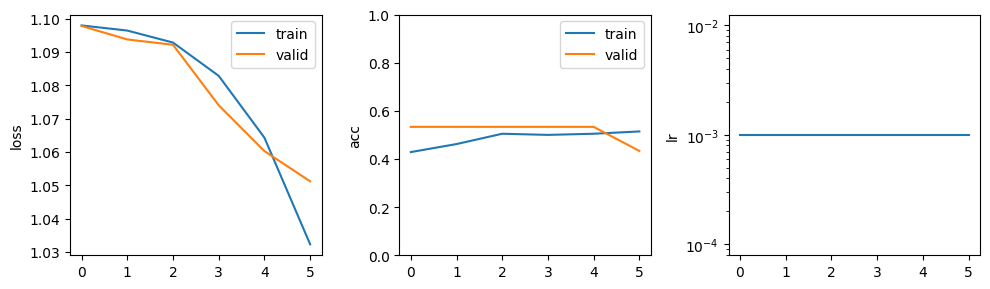

In [20]:
# plot history
fig, axs = plt.subplots(1, 3, figsize=(10, 3))
axs[0].plot(train_losses, label='train')
axs[0].plot(valid_losses, label='valid')
            
axs[0].set_ylabel('loss')
axs[0].legend()
axs[1].plot(train_accuracies, label='train')
axs[1].plot(valid_accuracies, label='valid')
axs[1].set_ylabel('acc')
axs[1].set_ylim(0, 1)
axs[1].legend()
axs[2].plot(lrs)
axs[2].set_ylabel('lr')
axs[2].set_yscale('log')
plt.tight_layout()
plt.show()